In [7]:
import os
import json
import shutil
import torch.optim
from torch.autograd import Variable
import torch.nn as nn
import random
import numpy as np
import torch.backends.cudnn as cudnn
from models.resnet import resnet  # The model construction
from models.densenet import densenet 
import torchvision
from trainer import train, validate, test
# Configuration Options
from utils import get_config

import torchvision.transforms as transforms
from data.folder_new import ImageFolder_new


import matplotlib.pyplot as plt



In [2]:
# Data loading code
# the dataloader for the test dataset.
data_path = '/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/metafgnet/'
target_test_path = os.path.join(data_path,"test","New_test_Photos")
batch_size = 128
workers = 4

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

test_loader = torch.utils.data.DataLoader(
        ImageFolder_new(target_test_path, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True
    )

In [3]:


images, labels = next(iter(test_loader))



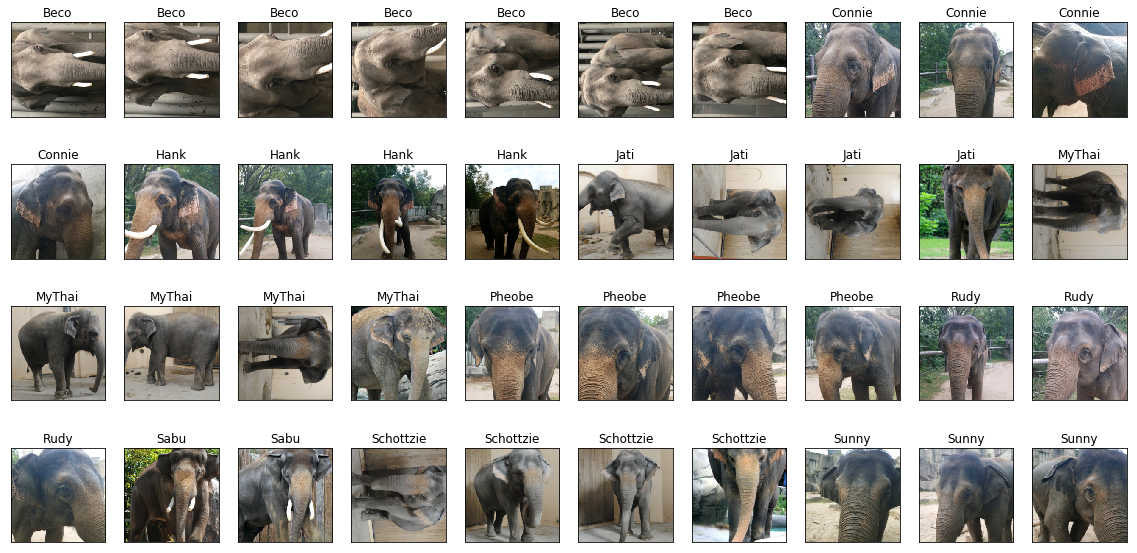

In [4]:
classes = ["Beco", "Connie", "Hank",  
                "Jati",  "Kamala",  "Maharani",  "MyThai", "Pheobe" ,"Rudy", "Sabu", 
                "Schottzie", "Spike", 
                "Sunny", "Swarna"]

def imshow(image,ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)


    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    #image = image.numpy()
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)

    ax.imshow(image)
        
    
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 10))

# display 20 images
for idx in np.arange(40):
    ax = fig.add_subplot(4, 40/4, idx+1, xticks=[], yticks=[])

    imshow(np.array(images[idx]),ax=ax)
    ax.set_title(classes[labels[idx]])

In [5]:
from collections import namedtuple

d = get_config(config="configs/elephant.yaml")
d["log"] =""
args = namedtuple("args", d.keys())(*d.values())
log = args.log + '_' + args.arch + '_' + args.dataset + '_' + str(args.batch_size) + 'Timg_' + args.auxiliary_dataset                + '_' + str(args.batch_size_source) + 'Simg_Meta_train_Lr' + str(args.meta_train_lr) + '_' +               str(args.num_updates_for_gradient)


In [8]:
model_source, model_target = densenet(args)
# define-multi GPU
model_source = torch.nn.DataParallel(model_source).cuda()
model_target = torch.nn.DataParallel(model_target).cuda()

==> creating model 'densenet121' 
args(log_iter=10, log_folder='./checkpoints/densenet', test_freq=10, record_freq=10, print_freq=1, workers=4, max_iterations=2000, batch_size=64, batch_size_source=64, learning_rate=0.001, momentum=0.9, weight_decay='1e-5', schedule=[20, 40, 60, 80, 100], gamma=0.1, lr=0.1, meta_train_lr=0.001, num_updates_for_gradient=1, meta_sgd=False, second_order_grad=False, first_meta_update=False, start_epoch=0, resume=False, test_only=False, pretrained=False, pretrained_checkpoint='', epochs=100, arch='densenet121', data_root='./data/original/', data_path='/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/metafgnet/target', data_path_source='/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/metafgnet/source', auxiliary_dataset='/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/metafgnet/source', dataset='/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/metafgnet/target', testdataset='/share/jproject/fg508/mchivuku

/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [9]:
## Resume Model
# raise ValueError('the resume function is not finished')
resume = "./checkpoints/densenet/model_best.pth.tar"

print("==> loading checkpoints '{}'".format(resume))

checkpoint = torch.load(resume)
#meta_train_lr = checkpoint['meta_train_lr']
best_prec1 = checkpoint['best_prec1']

model_source.load_state_dict(checkpoint['source_state_dict'])
model_target.load_state_dict(checkpoint['target_state_dict'])
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD([
            {'params': model_source.module.resnet_conv.parameters(), 'name': 'new-added'},
            {'params': model_source.module.fc.parameters(), 'name': 'new-added'},
            {'params': model_target.module.fc.parameters(), 'name': 'new-added'},
        ],
                                    lr=args.lr,
                                    momentum=args.momentum,
                                    weight_decay=float(args.weight_decay))

optimizer.load_state_dict(checkpoint['optimizer'])

print("==> loaded checkpoint '{}'(epoch {})"
      .format(resume, checkpoint['epoch']))

==> loading checkpoints './checkpoints/densenet/model_best.pth.tar'
==> loaded checkpoint './checkpoints/densenet/model_best.pth.tar'(epoch 40)


In [10]:
test(test_loader, model_source, model_target, criterion, 700,args)

Te T: [700][0/1]	T@1 15.000 (15.000)	T@5 52.500 (52.500)	LT 2.6210 (2.6210)
 * Test Dataset (/share/jproject/fg508/mchivuku/datasets/asian_elephant/models/metafgnet/test/) Prec@1 15.000 Prec@5 52.500


/N/u/mchivuku/asian_elephant_facial_recognition/MetaFGNet/trainer.py:413: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  losses_target.update(loss_target.data[0], test_images.size(0))


In [11]:
checkpoint

{'epoch': 40,
 'arch': 'densenet121',
 'source_state_dict': OrderedDict([('module.resnet_conv.features.conv0.weight',
               tensor([[[[-0.0861,  0.0406,  0.0470,  ..., -0.1456, -0.0983, -0.0805],
                         [-0.1450, -0.1254, -0.1102,  ..., -0.2084,  0.1008, -0.1059],
                         [-0.2391, -0.0184, -0.2015,  ..., -0.0405,  0.0896,  0.1338],
                         ...,
                         [ 0.0176, -0.0721, -0.2189,  ..., -0.0121, -0.2085, -0.0824],
                         [ 0.1441,  0.1341,  0.1151,  ..., -0.2285,  0.0340, -0.1254],
                         [-0.0803, -0.1715, -0.2069,  ..., -0.0373,  0.0995,  0.2741]],
               
                        [[-0.1100, -0.1878, -0.1823,  ...,  0.0687, -0.0657,  0.1403],
                         [-0.2112, -0.3278, -0.0870,  ...,  0.1318, -0.0569,  0.2923],
                         [ 0.0901,  0.1180, -0.1489,  ..., -0.0126, -0.0345, -0.0596],
                         ...,
                      